## Imports

In [1]:
# script libraries
import data
# data handling
import pandas as pd
import numpy as np
# machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from hist import Hist
import hist

# Get our waveform training set

In [2]:
# read in waveform dataframe

waveforms = pd.read_parquet('../../../Data/all_msci_waveforms_df.parquet')
print('Waveforms Set')
waveforms.info()
waveforms.head()

Waveforms Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18139 entries, 0 to 18138
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   runID    18139 non-null  uint64
 1   eventID  18139 non-null  uint64
 2   times    18139 non-null  object
 3   samples  18139 non-null  object
 4   length   18139 non-null  int64 
dtypes: int64(1), object(2), uint64(2)
memory usage: 708.7+ KB


,runID,eventID,times,samples,length
0,6940,941,"[-1442.0, -1432.0, -1422.0, -1412.0, -1402.0, ...","[0.00371349323540926, 0.011231761425733566, 0....",450
1,6940,2797,"[-3062.0, -3052.0, -3042.0, -3032.0, -3022.0, ...","[-0.0005877960938960314, 0.0009018611162900925...",865
2,6940,3177,"[-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...","[0.00036996949347667396, -0.000351915950886905...",1101
3,6940,3705,"[-522.0, -512.0, -502.0, -492.0, -482.0, -472....","[0.0011612486559897661, 0.009089636616408825, ...",600
4,6940,6386,"[-2032.0, -2022.0, -2012.0, -2002.0, -1992.0, ...","[0.00023173866793513298, 0.0002317386679351329...",466


In [3]:
# read in tritium and background datasets and combine

trit_data = pd.read_csv('../../../Data/tritium_ML_data.csv')
bkg_data = pd.read_csv('../../../Data/bg_sr1_vetoes_gassplit.csv')
orig_train = pd.concat([trit_data, bkg_data], ignore_index=True)
orig_train = orig_train.drop('Unnamed: 0', axis = 1)
print('Original Dataset')
orig_train.info()
orig_train.head()

Original Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23517 entries, 0 to 23516
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   runID             23517 non-null  int64  
 1   eventID           23517 non-null  int64  
 2   area              23517 non-null  float64
 3   max_pulse_height  23517 non-null  float64
 4   ext_elec          23517 non-null  float64
 5   x                 23517 non-null  float64
 6   y                 23517 non-null  float64
 7   r                 23517 non-null  float64
 8   S2_width          23517 non-null  float64
 9   label             23517 non-null  int64  
 10  type              23517 non-null  object 
 11  dt10_05           23517 non-null  float64
 12  dt25_10           23517 non-null  float64
 13  dt50_25           23517 non-null  float64
 14  dt75_50           23517 non-null  float64
 15  dt90_75           23517 non-null  float64
 16  dt95_90           23517

,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,S2_width,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90
0,8155,22203,6436.112305,2.266133,136.734912,-45.228909,-22.735205,50.621573,6930.0,2,tritium,320.0,570.0,680.0,780.0,740.0,380.0
1,8155,22291,5628.426270,2.136970,119.575659,10.828576,30.402670,32.273525,7150.0,2,tritium,360.0,770.0,850.0,740.0,690.0,430.0
2,8155,22426,9805.306641,4.920897,208.313292,6.381312,32.306606,32.930806,7000.0,2,tritium,270.0,480.0,580.0,570.0,510.0,300.0
3,8170,57019,6517.310059,2.850476,138.459955,-24.567440,4.934042,25.058010,5800.0,2,tritium,270.0,550.0,640.0,620.0,580.0,400.0
4,8144,57701,18532.921875,5.245479,393.731079,32.857990,30.225632,44.645675,8690.0,2,tritium,440.0,770.0,930.0,790.0,620.0,330.0


- Binary Classification: 
    - Background - 0
    - Signal - 1
- Multi-class Classification:
    - Cathode - 0
    - Gate - 1
    - Tritium - 2

In [4]:
# Remove gas events from our waveform set
# Then set background events to a label=0 and signal calibration events to a label=1

final_dataset = data.waveforms_of_truth(waveforms, orig_train)
df_gas_cut = final_dataset[final_dataset["type"] != 'gas']
# df_gas_cut.loc[df_gas_cut["type"] == "tritium", "label"] = 1
# df_gas_cut.loc[df_gas_cut["type"] == "gate", "label"] = 0
df_gas_cut.info()
df_gas_cut.head()

Rows with length = 0 have been removed from the waveform data set
<class 'pandas.core.frame.DataFrame'>
Index: 9686 entries, 2 to 17602
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   runID             9686 non-null   uint64 
 1   eventID           9686 non-null   uint64 
 2   times             9686 non-null   object 
 3   samples           9686 non-null   object 
 4   length            9686 non-null   int64  
 5   area              9686 non-null   float64
 6   max_pulse_height  9686 non-null   float64
 7   ext_elec          9686 non-null   float64
 8   x                 9686 non-null   float64
 9   y                 9686 non-null   float64
 10  r                 9686 non-null   float64
 11  S2_width          9686 non-null   float64
 12  label             9686 non-null   int64  
 13  type              9686 non-null   object 
dtypes: float64(7), int64(2), object(3), uint64(2)
memory usage: 1.1+ MB


,runID,eventID,times,samples,length,area,max_pulse_height,ext_elec,x,y,r,S2_width,label,type
2,6940,3177,"[-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...","[0.00036996949347667396, -0.000351915950886905...",1101,9605.476562,2.721810,204.067911,42.940289,28.632875,51.611142,11120.0,0,cathode
3,6940,3705,"[-522.0, -512.0, -502.0, -492.0, -482.0, -472....","[0.0011612486559897661, 0.009089636616408825, ...",600,1831.674072,2.608893,38.913832,23.994717,41.210274,47.686823,1920.0,1,gate
6,6940,7831,"[-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...","[0.0009631378925405443, 0.0009631378925405443,...",932,8454.574219,2.998639,179.617043,-10.792992,-21.832264,24.354392,8570.0,0,cathode
8,6940,9904,"[-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...","[-0.003676149994134903, -0.004674938507378101,...",525,10806.775391,7.274445,229.589450,45.577667,18.305967,49.116516,3760.0,1,gate
11,6940,15136,"[-823.0, -813.0, -803.0, -793.0, -783.0, -773....","[-0.004523166920989752, 0.0026921471580863, -0...",640,11460.135742,8.490430,243.470060,28.943817,44.150917,52.792500,2810.0,1,gate


## Get the weights of the dataset based on S2 size

In [5]:
electron_axis = hist.axis.Regular(100,5,500,name="electrons",
                           label="Extracted electrons",flow=False)

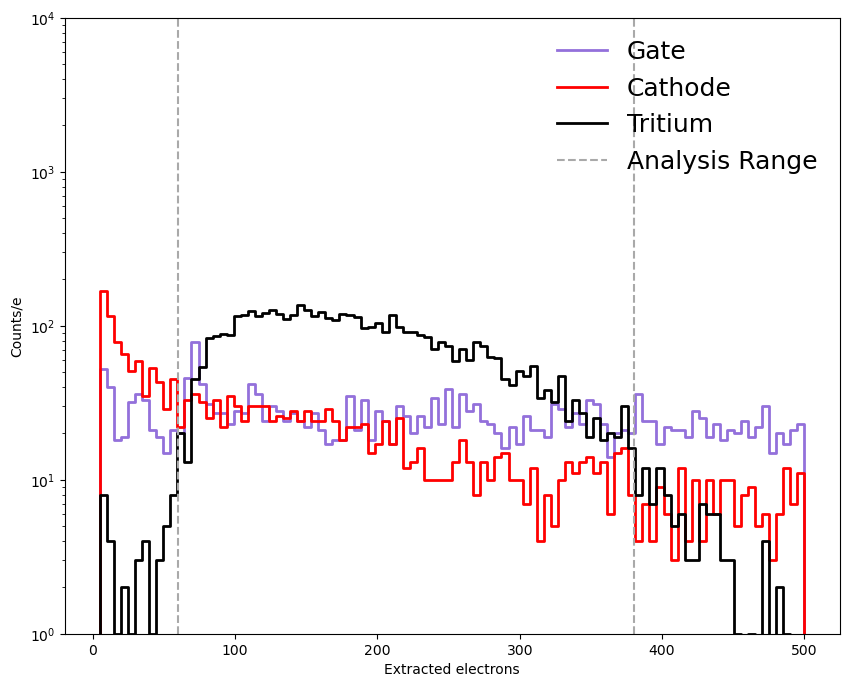

In [6]:
gate_hist = Hist(electron_axis)
gate_cut = df_gas_cut.type == "gate"
gate_hist.fill(df_gas_cut.ext_elec[gate_cut])

# gas_hist = Hist(electron_axis)
# gas_cut = padded_data.type == "gas"
# gas_hist.fill(padded_data.ext_elec[gas_cut])

cath_hist = Hist(electron_axis)
cath_cut = df_gas_cut.type == "cathode"
cath_hist.fill(df_gas_cut.ext_elec[cath_cut])

trit_hist = Hist(electron_axis)
trit_cut = df_gas_cut.type == "tritium"
trit_hist.fill(df_gas_cut.ext_elec[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
# gas_hist.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[1,10000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [7]:
# implementing thresholds
thresh_cut = (60 < df_gas_cut.ext_elec) & (df_gas_cut.ext_elec < 380)
df_gas_and_thresh_cut = df_gas_cut[thresh_cut].reset_index().drop('index', axis = 1)

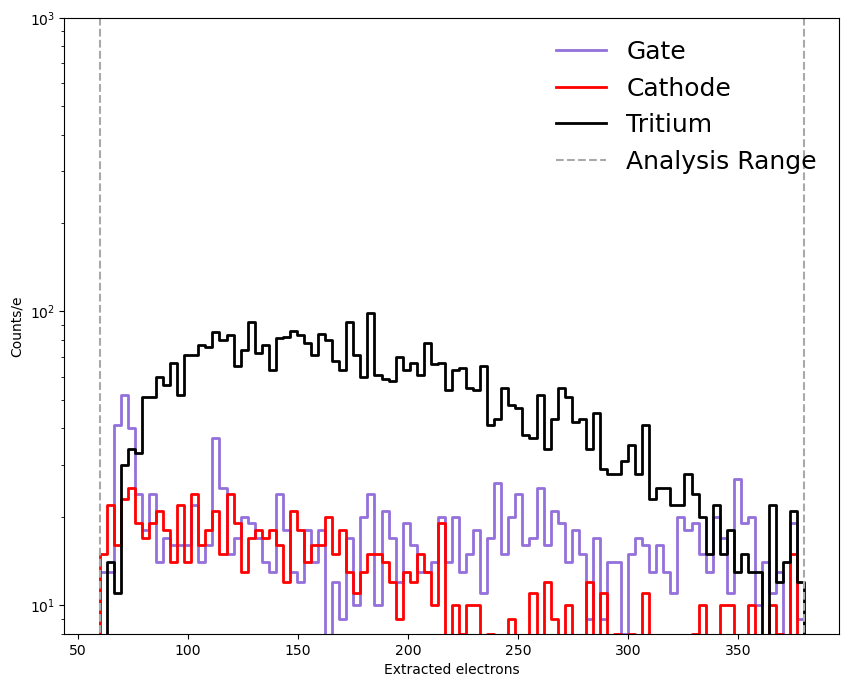

In [8]:
# histogram with threshold data
electron_axis2 = hist.axis.Regular(100,60,380,name="electrons",
                           label="Extracted electrons",flow=False)

gate_hist2 = Hist(electron_axis2)
gate_cut2 = df_gas_and_thresh_cut.type == "gate"
gate_hist2.fill(df_gas_and_thresh_cut.ext_elec[gate_cut2])

cath_hist2 = Hist(electron_axis2)
cath_cut2 = df_gas_and_thresh_cut.type == "cathode"
cath_hist2.fill(df_gas_and_thresh_cut.ext_elec[cath_cut2])

trit_hist2 = Hist(electron_axis2)
trit_cut2 = df_gas_and_thresh_cut.type == "tritium"
trit_hist2.fill(df_gas_and_thresh_cut.ext_elec[trit_cut2])

# gas_hist2 = Hist(electron_axis2)
# gas_cut2 = padded_data.type == "gas"
# gas_hist2.fill(padded_data.ext_elec[gas_cut2])


fig, ax = plt.subplots(figsize=(10, 8))
gate_hist2.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist2.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist2.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
# gas_hist2.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[8,1000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [9]:
#weighting data w/o gas events 
weight_list = []

for ii in range(df_gas_and_thresh_cut.shape[0]):
    if df_gas_and_thresh_cut.type[ii] == 'gate':
        index = np.searchsorted(gate_hist2.to_numpy()[1],df_gas_and_thresh_cut.ext_elec[ii]) - 1
        bin_counts = gate_hist2[index]
    elif df_gas_and_thresh_cut.type[ii] == 'cathode':
        index = np.searchsorted(cath_hist2.to_numpy()[1],df_gas_and_thresh_cut.ext_elec[ii]) - 1
        bin_counts = cath_hist2[index]
    elif df_gas_and_thresh_cut.type[ii] == 'tritium':
        index = np.searchsorted(trit_hist2.to_numpy()[1],df_gas_and_thresh_cut.ext_elec[ii]) - 1
        bin_counts = trit_hist2[index]     
    weight_list.append(1/bin_counts)
        
df_gas_and_thresh_cut['weights_no_gas'] = weight_list
print(df_gas_and_thresh_cut['weights_no_gas'].to_numpy().shape)

(7782,)


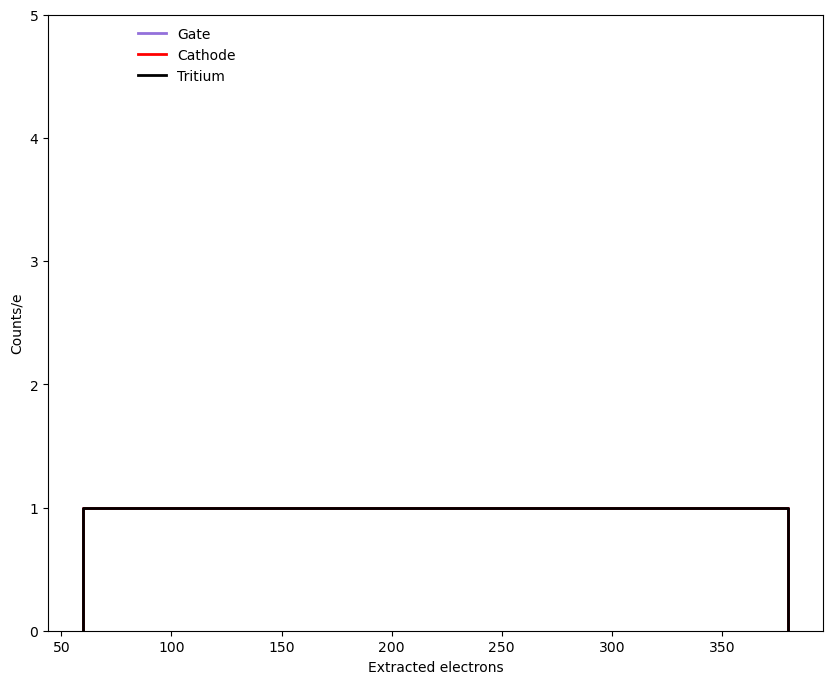

In [10]:
norm_gate_hist = Hist(electron_axis2)
norm_gate_hist.fill(df_gas_and_thresh_cut.ext_elec[gate_cut2],weight = df_gas_and_thresh_cut.weights_no_gas[gate_cut2])

norm_cath_hist = Hist(electron_axis2)
norm_cath_hist.fill(df_gas_and_thresh_cut.ext_elec[cath_cut2],weight = df_gas_and_thresh_cut.weights_no_gas[cath_cut2])

norm_trit_hist = Hist(electron_axis2)
norm_trit_hist.fill(df_gas_and_thresh_cut.ext_elec[trit_cut2],weight = df_gas_and_thresh_cut.weights_no_gas[trit_cut2])

fig, ax = plt.subplots(figsize=(10, 8))
norm_gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
norm_cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
norm_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

ax.set(xlabel='Extracted electrons',ylabel='Counts/e',ylim=[0,5])
ax.legend(bbox_to_anchor=(0.1,1),loc='upper left',frameon=False)

plt.show()

In [11]:
#some statistcs 
mean_length = np.mean(df_gas_and_thresh_cut.length)
std_length = np.std(df_gas_and_thresh_cut.length)
max_length = df_gas_and_thresh_cut.length.max()
print('The mean length is {} and standard deviation is {}. The max length is {}, which is {} sigma from the mean.'.format(mean_length,std_length,max_length,(max_length-mean_length)/std_length))

The mean length is 771.5612952968388 and standard deviation is 193.00747168226178. The max length is 1828, which is 5.473563771885067 sigma from the mean.


## Final ML Datasets

(excluing remove for now)
sigma -  0,1,2,3,4,5
gaussian - std = 0.01,0.02,0.05,0.1 
constant
edge
reflect

In [12]:
#creating all the padded datasets 
sigma_list=[0,1,2,3,4,5]
std_list=[0.01,0.02,0.05,0.1]
type_list=['gaussian','constant','edge','reflect']
gauss_names=['gauss0.01','gauss0.02','gauss0.05','gauss0.1']
#for sigma in sigma_list:
#    data.pad_sigma(df_gas_and_thresh_cut,sigma,'crop')
for i in range(len(std_list)):
    data.pad_waveforms(df_gas_and_thresh_cut,gauss_names[i],padding_type='gaussian',std=std_list[i])
data.pad_waveforms(df_gas_and_thresh_cut,padding_name='constant_padding',padding_type='constant')
data.pad_waveforms(df_gas_and_thresh_cut,padding_name='edge_padding',padding_type='edge')
data.pad_waveforms(df_gas_and_thresh_cut,padding_name='reflect_padding',padding_type='reflect')

,runID,eventID,times,samples,length,area,max_pulse_height,ext_elec,x,y,...,label,type,weights_no_gas,gauss0.01,gauss0.02,gauss0.05,gauss0.1,constant_padding,edge_padding,reflect_padding
0,6940,3177,"[-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...","[0.00036996949347667396, -0.000351915950886905...",1101,9605.476562,2.721810,204.067911,42.940289,28.632875,...,0,cathode,0.066667,"[0.01975134438790963, -0.008059609101796587, -...","[0.017197204018290696, 0.004203278440308333, -...","[-0.009339099025078195, -0.060234225697419486,...","[-0.16725127870121115, -0.11485853201953189, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,6940,7831,"[-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...","[0.0009631378925405443, 0.0009631378925405443,...",932,8454.574219,2.998639,179.617043,-10.792992,-21.832264,...,0,cathode,0.076923,"[-0.014218662825826211, -0.005850424137897562,...","[-0.0110526726120803, -0.0015445859720700195, ...","[-0.0670719453923467, -0.0039868188034315796, ...","[-0.132105894578262, -0.13173500325171636, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,6940,9904,"[-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...","[-0.003676149994134903, -0.004674938507378101,...",525,10806.775391,7.274445,229.589450,45.577667,18.305967,...,1,gate,0.066667,"[-4.720838642652896e-05, 0.008129699435711664,...","[-0.018233990484477432, -0.010854213380838543,...","[-0.0061499837758974465, -0.05017239518034973,...","[0.07104690594482942, 0.014753425067433457, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,6940,15136,"[-823.0, -813.0, -803.0, -793.0, -783.0, -773....","[-0.004523166920989752, 0.0026921471580863, -0...",640,11460.135742,8.490430,243.470060,28.943817,44.150917,...,1,gate,0.066667,"[0.013761317214807552, 0.02208370728259837, 0....","[-0.015515050991650702, 0.03620513279715932, -...","[-0.03057852094922749, 0.055639642830725825, 0...","[-0.0072034565988366, 0.05864315229651981, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,6940,16478,"[-813.0, -803.0, -793.0, -783.0, -773.0, -763....","[-0.009625015780329704, -0.004182628821581602,...",656,11764.575195,8.766376,249.937863,-22.589451,23.071259,...,1,gate,0.041667,"[0.02137782289480086, 0.006382597045483002, -0...","[-0.028283240037797475, -0.006197129855698634,...","[0.07378631626030056, -0.07894032123153749, 0....","[-0.014437601986196933, -0.05616073432703277, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7777,8172,146375,"[-1642.0, -1632.0, -1622.0, -1612.0, -1602.0, ...","[0.0006020283326506615, -0.0001504611573182046...",447,3772.321533,2.478832,80.142799,15.835625,13.181137,...,2,tritium,0.019608,"[-0.0018147321719391976, 0.006375158523578497,...","[-0.027256905840470528, 0.0055370450394220455,...","[-0.15508320835071893, 0.03862988731123047, 0....","[0.08198997609105124, 0.1407447234877046, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7778,8172,146918,"[-2062.0, -2052.0, -2042.0, -2032.0, -2022.0, ...","[0.0006466679042205215, 0.0014018205692991614,...",671,6177.657715,3.737255,131.244056,11.203719,47.689232,...,2,tritium,0.013889,"[-0.00607783994756327, 0.008527625927033789, 0...","[-0.007103863061356006, 0.031566268516636506, ...","[-0.09242793006248923, -0.020862074324228996, ...","[-0.0263096

In [17]:
data_list=['gauss0.01','gauss0.02','gauss0.05','gauss0.1','constant_padding','edge_padding','reflect_padding']
ML_data={name:data.make_ML_data(df_gas_and_thresh_cut,name) for name in data_list}

[[ 2.65424596e-04  2.23764553e-05  5.97853198e-04 ... -8.45206161e-04
   2.08128836e-04 -4.14388602e-04]
 [ 1.69926375e-04 -2.68785433e-04  8.53177106e-05 ... -3.69676588e-05
   1.53568146e-04 -1.20098475e-03]
 [-2.66378917e-05 -5.40685980e-04  4.19776631e-04 ... -4.79883759e-04
  -4.54025783e-04 -2.60038156e-04]
 ...
 [ 4.60285739e-04 -2.76794737e-04 -2.76174207e-04 ... -6.60240715e-04
  -1.14917635e-04  8.53554310e-04]
 [ 2.46825342e-04  1.04490820e-04 -2.00576453e-04 ... -6.03961605e-04
   8.19287098e-05  3.16470102e-04]
 [ 2.67358509e-04  3.89945395e-04  4.39297721e-04 ...  8.46644923e-05
   5.06598704e-05 -1.43344307e-04]]


# Making the model

#### Going to start with input layer with no. neurons as the length of the waveform arrays, one fully connected hidden layer, and an output layer of two neurons

In [25]:
# #best so far
paddedCNN = keras.Sequential([
    Masking(mask_value=0., input_shape=(input_length, 1)), # basically means the padded zeros are ignored, unsure exactly how this works
    Conv1D(filters=32,kernel_size=3,activation='relu', padding='valid'),
    # Conv1D(filters=64,kernel_size=3,activation='relu', input_shape=(input_length, 1)),
    MaxPooling1D(3),
    
    Conv1D(filters=64,kernel_size=5,activation='relu', padding='valid'),
    MaxPooling1D(3),

    Conv1D(filters=128,kernel_size=9,activation='relu', padding='valid'),
    MaxPooling1D(3),

    Flatten(),
    # Dropout(0.2),
    # Dense(120, activation='relu'),
    Dense(60, activation='leaky_relu'),
    Dense(10, activation='leaky_relu'),
    # Dropout(0.2),
    Dense(3, activation='softmax')
])

# paddedCNN = keras.Sequential([
#     Masking(mask_value=0., input_shape=(input_length, 1)), # basically means the padded zeros are ignored, unsure exactly how this works
#     Conv1D(filters=16,kernel_size=3,activation='relu', padding='valid'),
#     Conv1D(filters=16,kernel_size=3,activation='relu', padding='valid'),
#     MaxPooling1D(2),
    
#     Conv1D(filters=32,kernel_size=5,activation='relu', padding='valid'),
#     Conv1D(filters=32,kernel_size=3,activation='relu', padding='valid'),
#     MaxPooling1D(2),

#     Flatten(),
#     # Dropout(0.2),
#     # Dense(120, activation='relu'),
#     Dense(60, activation='leaky_relu'),
#     Dense(10, activation='leaky_relu'),
#     # Dropout(0.2),
#     Dense(3, activation='softmax')
# ])
paddedCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 1351, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, 1349, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 449, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 445, 64)           10304     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 148, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 140, 128)          7

In [26]:
paddedCNN.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',#'binary_crossentropy',
                 metrics=['accuracy'],
                 weighted_metrics=['accuracy'])

In [27]:
[print(i.shape, i.dtype) for i in paddedCNN.inputs]
[print(o.shape, o.dtype) for o in paddedCNN.outputs]
[print(l.name, l.input_shape, l.dtype) for l in paddedCNN.layers]

(None, 1351, 1) <dtype: 'float32'>
(None, 3) <dtype: 'float32'>
masking (None, 1351, 1) float32
conv1d (None, 1351, 1) float32
max_pooling1d (None, 1349, 32) float32
conv1d_1 (None, 449, 32) float32
max_pooling1d_1 (None, 445, 64) float32
conv1d_2 (None, 148, 64) float32
max_pooling1d_2 (None, 140, 128) float32
flatten (None, 46, 128) float32
dense (None, 5888) float32
dense_1 (None, 60) float32
dense_2 (None, 10) float32


[None, None, None, None, None, None, None, None, None, None, None]

In [28]:
hist_paddedCNN = paddedCNN.fit(X_train,y_train,epochs=40, validation_split=0.2, shuffle=True, sample_weight=W_train)

Epoch 1/40
146/146 [==============================] - 6s 35ms/step - loss: 0.0233 - accuracy: 0.6525 - weighted_accuracy: 0.7411 - val_loss: 0.0161 - val_accuracy: 0.8399 - val_weighted_accuracy: 0.8369
Epoch 2/40
146/146 [==============================] - 5s 33ms/step - loss: 0.0150 - accuracy: 0.7879 - weighted_accuracy: 0.8513 - val_loss: 0.0140 - val_accuracy: 0.7620 - val_weighted_accuracy: 0.8597
Epoch 3/40
146/146 [==============================] - 5s 36ms/step - loss: 0.0134 - accuracy: 0.8158 - weighted_accuracy: 0.8661 - val_loss: 0.0165 - val_accuracy: 0.8262 - val_weighted_accuracy: 0.8163
Epoch 4/40
146/146 [==============================] - 5s 36ms/step - loss: 0.0132 - accuracy: 0.8181 - weighted_accuracy: 0.8670 - val_loss: 0.0154 - val_accuracy: 0.7449 - val_weighted_accuracy: 0.8468
Epoch 5/40
146/146 [==============================] - 5s 35ms/step - loss: 0.0123 - accuracy: 0.8271 - weighted_accuracy: 0.8791 - val_loss: 0.0142 - val_accuracy: 0.8425 - val_weighted_ac

## Evaluating the model

In [29]:
print('Test Loss, Test Accuracy]')
paddedCNN.evaluate(X_test,y_test, sample_weight=W_test)

Test Loss, Test Accuracy]
61/61 [==============================] - 1s 8ms/step - loss: 0.0181 - accuracy: 0.8643 - weighted_accuracy: 0.8839


[0.01812545396387577, 0.8643370866775513, 0.883882999420166]

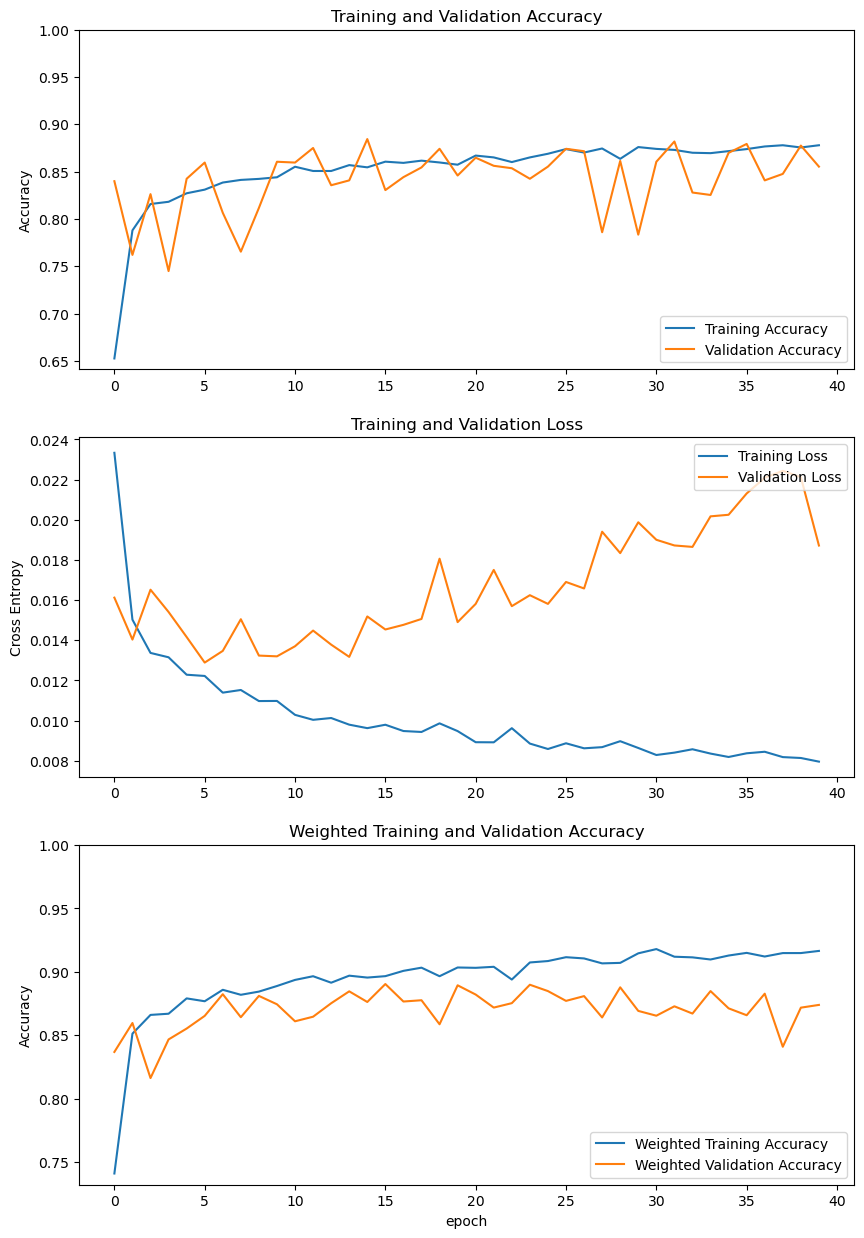

In [30]:
# plotting training history

acc = hist_paddedCNN.history['accuracy']
val_acc = hist_paddedCNN.history['val_accuracy']
w_acc = hist_paddedCNN.history['weighted_accuracy']
w_val_acc = hist_paddedCNN.history['val_weighted_accuracy']

loss = hist_paddedCNN.history['loss']
val_loss = hist_paddedCNN.history['val_loss']
# w_loss = hist_paddedCNN.history['weighted_loss']
# w_val_loss = hist_paddedCNN.history['val_weighted_loss']

plt.figure(figsize=(10, 15))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

# plotting weighted mertrics

plt.subplot(3, 1, 3)
plt.plot(w_acc, label='Weighted Training Accuracy')
plt.plot(w_val_acc, label='Weighted Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Weighted Training and Validation Accuracy')
plt.xlabel('epoch')

plt.show()

In [31]:
# generating confusion matrix info

#y_probs = paddedNN.predict(X_test)
# y_predicted_label = (y_probs > 0.5).astype(int)
#y_probs[0], y_predicted_label[0]
#print(y_predicted)

y_predicted = paddedCNN.predict(X_test)
y_predicted_label = [np.argmax(i) for i in y_predicted]

61/61 [==============================] - 1s 8ms/step


Text(95.72222222222221, 0.5, 'Truth')

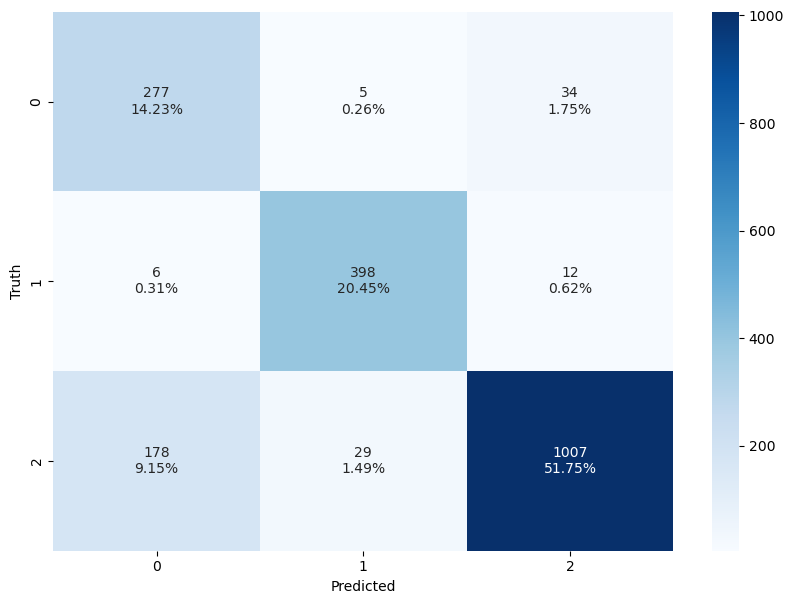

In [32]:
# plotting confusion matrix

# plt.figure(figsize = (10,7))
# sns.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_label),
#            annot=True, 
#            fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')

plt.figure(figsize = (10,7))
cf_matrix = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_label).numpy()

# group_names = ['True Cathode','False Gate', 'False Signal', 
#                'False Cathode','True Gate', 'False Signal',
#                'False']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
#labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
          #zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')